# Insight Demo for AI Fellowship

In [37]:
from sbm import *
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')
%matplotlib inline

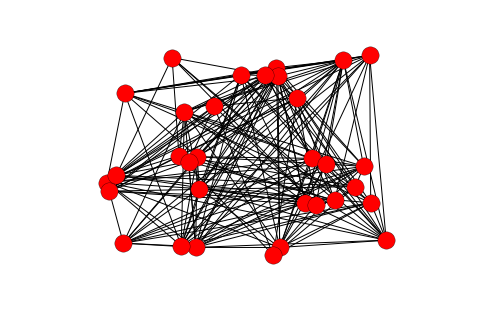

In [40]:
big_community=20
small_community=12
P_in = 0.7
P_out = 0.04
G1=nx.nx.random_partition_graph([big_community,small_community], p_in=P_in, p_out =P_out)
#0.8 are "easier parameters"
Adj = nx.adjacency_matrix(G1).todense()
#random layout
nx.draw(G1, nx.random_layout(G1))
#try spectral, spring
#nx.draw(G1, nx.spring_layout(G1))
#nx.draw(G1, nx.spectral_layout(G1))

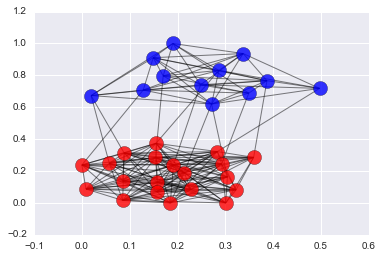

In [41]:
pos=nx.spring_layout(G1)
# nodes
nx.draw_networkx_nodes(G1,pos,
                       nodelist=[i for i in xrange(big_community)],
                       node_color='r',
                       node_size=200,
                   alpha=0.8)
nx.draw_networkx_nodes(G1,pos,
                       nodelist= [i+big_community for i in xrange(small_community)],
                       node_color='b',
                       node_size=200,
                   alpha=0.8)

# edges
nx.draw_networkx_edges(G1,pos,width=1.0,alpha=0.5)


In [42]:
#PARAMTERS

big_community=32
small_community=32
data_points = 256*8
dim = big_community+small_community
epsilon = 1e-3
l_rate = 0.3
batch_size=8
P_IN = 0.4
P_OUT = 0.1

big_community_test = 32
small_community_test = 32
dim_test=big_community_test+small_community_test

DATA_triple = DATA_SBM(big_community=big_community, 
                       small_community=small_community, 
                       p_in = P_IN,  p_out = P_OUT, 
                       data_points=data_points)
DATA = [i[0] for i in DATA_triple]
LABELS = [i[1] for i in DATA_triple]
DIRAC = [i[2] for i in DATA_triple]
PERMS = [i[3] for i in DATA_triple]

In [43]:
def batch_norm_wrapper(inputs, batch_mean=None, batch_var=None, beta=None, scale=None, epsilon=None, is_training=True):
    
    pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
    pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)

    if is_training:
        mean, var = tf.nn.moments(inputs,[0])
        return tf.nn.batch_normalization(inputs, batch_mean, batch_var, beta, scale, epsilon)
    else:
        return tf.nn.batch_normalization(inputs, pop_mean, pop_var, beta, scale, epsilon)

def layer_accuracy(input_vector,
                   filter_touse, 
                   beta, scale,
                   batch_size, 
        signal_dim_in, signal_dim_out, channel_dim, SD, 
          cascade_list, dim,
          XY,
         filter_name=None, 
         scale_name=None, 
         beta_name=None, 
         relu=True):
    """A layer of the GNN to evaluate accuracy
    We assume that signal_dim_in does not include the dirac signal and degree signal"""
    cascade_2 = [tf.batch_matmul(cascade_list[i], input_vector[j]) for j in xrange(signal_dim_in+2) for i in xrange(channel_dim)] 
    cascade_2_reshape = tf.reshape(cascade_2, shape=[signal_dim_in+2, channel_dim, batch_size, dim])
    input_2 = tf.transpose(cascade_2_reshape, [2, 1, 3, 0])
    op2 = tf.nn.conv2d(input_2, filter_touse, strides=[1, 1, 1, 1], padding='VALID')
    batch_mean2, batch_var2 = tf.nn.moments(op2, [0])
    BN2 = batch_norm_wrapper(op2, batch_mean2, batch_var2, 
                                   beta, scale, epsilon)
    if relu:
        BN2 = tf.nn.relu(BN2)

    return BN2


def cascadeProcess(batch_size,
              Adj, Y_prepare, dim):


    A = tf.cast(Adj, dtype=tf.float32)
    D = tf.reduce_sum(A, 1)
    D_sqrt = tf.sqrt(D)
    D_sqrt_inv = tf.matrix_diag(tf.reciprocal(D_sqrt))

    Iden = tf.reshape(tf.concat(0, [tf.Variable(np.identity(dim), dtype=tf.float32, trainable=False)]*batch_size),
                       shape=[batch_size, dim, dim])
    Q = tf.batch_matmul(tf.batch_matmul(D_sqrt_inv, A), D_sqrt_inv)
    Q1 = tf.batch_matmul(Q, Q)
    Q2 = tf.batch_matmul(Q1, Q1)
    Q3 = tf.batch_matmul(Q2, Q2) 

    cascade_lst = [Iden, Q, Q1, Q2, Q3]
    channel_dim = len(cascade_lst)

    X = tf.expand_dims(D, 2)

    Y = tf.expand_dims(Y_prepare, 2)

    XY = tf.concat(0, [tf.expand_dims(X, 0), tf.expand_dims(Y, 0)])

    xy = tf.transpose(XY, perm=[1, 3, 2, 0])
    
    return XY, xy, cascade_lst


In [44]:
DIM = tf.cast(dim, dtype=tf.float32)
signal_dims = [2, 16, 16, 16, 16, 1]
SD = [1/(signal_dims[0]*tf.sqrt(DIM)), 
      1/(signal_dims[0]*tf.sqrt(DIM)),
      1/(signal_dims[0]*tf.sqrt(DIM)), 
     1/(signal_dims[0]*tf.sqrt(DIM)), 
     1/(signal_dims[0]*tf.sqrt(DIM))]

true_assignment_a= tf.placeholder(dtype=tf.float32, shape = [batch_size, None])
Adj = tf.placeholder(shape=[batch_size, None, None],dtype=tf.float32)
permutation = tf.placeholder(shape=[batch_size, None], dtype=tf.float32)

A = tf.cast(Adj, dtype=tf.float32)
D = tf.reduce_sum(A, 1)
D_sqrt = tf.sqrt(D)
D_sqrt_inv = tf.matrix_diag(tf.reciprocal(D_sqrt))

Iden = tf.reshape(tf.concat(0, [tf.Variable(np.identity(dim), dtype=tf.float32, trainable=False)]*batch_size),
                   shape=[batch_size, dim, dim])
Q = tf.batch_matmul(tf.batch_matmul(D_sqrt_inv, A), D_sqrt_inv)#tf.matmul(D, Adj, a_is_sparse=True)
Q1 = tf.batch_matmul(Q, Q)
Q2 = tf.batch_matmul(Q1, Q1)
Q3 = tf.batch_matmul(Q2, Q2) 

cascade_lst = [Iden, Q, Q1, Q2, Q3]
channel_dim = len(cascade_lst)

X = tf.expand_dims(D, 2)
Y_prepare = tf.placeholder(dtype=tf.float32, shape=[batch_size, None])
Y = tf.expand_dims(Y_prepare, 2)
XY = tf.concat(0, [tf.expand_dims(X, 0), tf.expand_dims(Y, 0)])
xy = tf.transpose(XY, perm=[1, 3, 2, 0])

cascade_1 = [tf.batch_matmul(cascade_lst[i], XY[j]) for j in xrange(2) for i in xrange(channel_dim)]
cascade_1_reshape = tf.reshape(cascade_1, shape=[2, channel_dim, batch_size, dim])


#LAYER ONE
input_1 = tf.transpose(cascade_1_reshape, [2, 1, 3, 0])
filter_1 = tf.Variable(tf.random_normal([channel_dim, 1, signal_dims[0], signal_dims[1]], 
                                        stddev=SD[0], dtype=tf.float32), trainable=True)
op1 = tf.nn.conv2d(input_1, filter_1, strides=[1, 1, 1, 1], padding='VALID')
batch_mean1, batch_var1 = tf.nn.moments(op1, [0])
scale1 = tf.Variable(tf.ones(signal_dims[1]))
beta1 = tf.Variable(tf.zeros(signal_dims[1]))
BN1 = batch_norm_wrapper(op1, batch_mean1, batch_var1, 
                               beta1, scale1, epsilon)
BN1_relu = tf.nn.relu(BN1)
zc1 = tf.transpose(tf.concat(3, [xy, BN1_relu]), perm=[3,0,2,1])


#LAYER TWO

cascade_2 = [tf.batch_matmul(cascade_lst[i], zc1[j]) for j in xrange(signal_dims[1]+2) for i in xrange(channel_dim)] 
cascade_2_reshape = tf.reshape(cascade_2, shape=[signal_dims[1]+2, channel_dim, batch_size, dim])
input_2 = tf.transpose(cascade_2_reshape, [2, 1, 3, 0])
filter_2 = tf.Variable(tf.random_normal([channel_dim, 1, signal_dims[1]+2, 
                                         signal_dims[2]], stddev=SD[1], dtype=tf.float32), trainable=True)
op2 = tf.nn.conv2d(input_2, filter_2, strides=[1, 1, 1, 1], padding='VALID')
batch_mean2, batch_var2 = tf.nn.moments(op2, [0])
scale2 = tf.Variable(tf.ones(signal_dims[2]))
beta2 = tf.Variable(tf.zeros(signal_dims[2]))
BN2 = batch_norm_wrapper(op2, batch_mean2, batch_var2, 
                               beta2, scale2, epsilon)
BN2_relu = tf.nn.relu(BN2)
zc2 = tf.transpose(tf.concat(3, [xy, BN2_relu]), perm=[3,0,2,1])

#LAYER THREE
cascade_3 = [tf.batch_matmul(cascade_lst[i], zc2[j]) for j in xrange(signal_dims[2]+2) for i in xrange(channel_dim)] 
cascade_3_reshape = tf.reshape(cascade_2, shape=[signal_dims[2]+2, channel_dim, batch_size, dim])
input_3 = tf.transpose(cascade_2_reshape, [2, 1, 3, 0])
filter_3 = tf.Variable(tf.random_normal([channel_dim, 1, signal_dims[2]+2,
                                         signal_dims[3]], stddev=SD[2], dtype=tf.float32), trainable=True)
op3 = tf.nn.conv2d(input_3, filter_3, strides=[1, 1, 1, 1], padding='VALID')
batch_mean3, batch_var3 = tf.nn.moments(op3, [0])
scale3 = tf.Variable(tf.ones(signal_dims[3]))
beta3 = tf.Variable(tf.zeros(signal_dims[3]))
BN3 = batch_norm_wrapper(op3, batch_mean3, batch_var3, 
                               beta3, scale3, epsilon)
BN3_relu = tf.nn.relu(BN3)
zc3 = tf.transpose(tf.concat(3, [xy, BN3_relu]), perm=[3,0,2,1])

#LAYER FOUR
cascade_4 = [tf.batch_matmul(cascade_lst[i], zc3[j]) for j in xrange(signal_dims[3]+2) for i in xrange(channel_dim)] 
cascade_4_reshape = tf.reshape(cascade_2, shape=[signal_dims[3]+2, channel_dim, batch_size, dim])
input_4 = tf.transpose(cascade_2_reshape, [2, 1, 3, 0])
filter_4 = tf.Variable(tf.random_normal([channel_dim, 1, signal_dims[3]+2,
                                         signal_dims[4]], stddev=SD[3], dtype=tf.float32), trainable=True)
op4 = tf.nn.conv2d(input_4, filter_4, strides=[1, 1, 1, 1], padding='VALID')
batch_mean4, batch_var4 = tf.nn.moments(op4, [0])
scale4 = tf.Variable(tf.ones(signal_dims[4]))
beta4 = tf.Variable(tf.zeros(signal_dims[4]))
BN4 = batch_norm_wrapper(op4, batch_mean4, batch_var4, 
                               beta4, scale4, epsilon)
BN4_relu = tf.nn.relu(BN4)
zc4 = tf.transpose(tf.concat(3, [xy, BN4_relu]), perm=[3,0,2,1])


#LAYER FIVE
cascade_5 = [tf.batch_matmul(cascade_lst[i], zc4[j]) for j in xrange(signal_dims[4]+2) for i in xrange(channel_dim)] 
cascade_5_reshape = tf.reshape(cascade_5, shape=[signal_dims[4]+2, channel_dim, batch_size, dim])
input_5 = tf.transpose(cascade_5_reshape, [2, 1, 3, 0])
filter_5 = tf.Variable(tf.random_normal([channel_dim, 1, signal_dims[4]+2, 
                                         signal_dims[5]], stddev=SD[4], dtype=tf.float32), trainable=True)
op5 = tf.nn.conv2d(input_5, filter_5, strides=[1, 1, 1, 1], padding='VALID')
batch_mean5, batch_var5 = tf.nn.moments(op5, [0])
scale5 = tf.Variable(tf.ones(signal_dims[5]))
beta5 = tf.Variable(tf.zeros(signal_dims[5]))
BN5 = batch_norm_wrapper(op5, batch_mean5, batch_var5, 
                               beta5, scale5, epsilon)
z5 =tf.sigmoid(tf.squeeze(tf.transpose(BN5, perm=[3,0,2,1])))

true_prob = true_assignment_a*(0.5)+0.5
cross_community_1 = -z5*tf.log(true_prob+1e-20)
cross_community_2 = -(1-z5)*tf.log((1-true_prob)+1e-20)

loss = tf.reduce_sum(cross_community_1)+tf.reduce_sum(cross_community_2) 
average_loss = loss/batch_size


#ACCURACY SUBGRAPH
#test data:
DATA_triple_test = DATA_SBM(big_community=big_community_test, 
           small_community=small_community_test, 
           p_in = P_IN,  p_out = P_OUT, 
           data_points=data_points)
DATA_test = [i[0] for i in DATA_triple_test]
LABELS_test = [i[1] for i in DATA_triple_test]
DIRAC_test = [i[2] for i in DATA_triple_test]

data_length = len(DATA_test)

true_assignment_data= tf.placeholder(dtype=tf.float32, shape = [data_length, None])
Adj_data = tf.placeholder(shape=[data_length, None, None],dtype=tf.float32)
Y_prepare_data = tf.placeholder(dtype=tf.float32, shape=[data_length, None])
XY_data, xy_data, cascade_list = cascadeProcess(batch_size=data_length,
              Adj=Adj_data, Y_prepare=Y_prepare_data, dim=dim_test)
data_length = len(DATA) #since we kept number of datapoints the same
tru_prob_data = true_assignment_data*(0.5)+0.5



a1 = layer_accuracy(input_vector=XY_data,
                   filter_touse=filter_1, 
                   beta=beta1, scale=scale1,
                   batch_size=len(DATA), 
        signal_dim_in=0, signal_dim_out=signal_dims[1], channel_dim=channel_dim, SD=SD[0], 
          cascade_list=cascade_list, dim=dim_test,
          XY=xy_data, 
         relu=True)
a1 = tf.transpose(tf.concat(3, [xy_data, a1]), perm=[3,0,2,1])

a2 = layer_accuracy(input_vector=a1,
                   filter_touse=filter_2, 
                   beta=beta2, scale=scale2,
                   batch_size=len(DATA), 
        signal_dim_in=signal_dims[1], signal_dim_out=signal_dims[2], channel_dim=channel_dim, SD=SD[1], 
          cascade_list=cascade_list, dim=dim_test,
          XY=xy_data, 
         relu=True)
a2 = tf.transpose(tf.concat(3, [xy_data, a2]), perm=[3,0,2,1])

a3 = layer_accuracy(input_vector=a2,
                   filter_touse=filter_3, 
                   beta=beta3, scale=scale3,
                   batch_size=len(DATA), 
        signal_dim_in=signal_dims[2], signal_dim_out=signal_dims[3], channel_dim=channel_dim, SD=SD[2], 
          cascade_list=cascade_list, dim=dim_test,
          XY=xy_data, 
         relu=True)
a3 = tf.transpose(tf.concat(3, [xy_data, a3]), perm=[3,0,2,1])

a4 = layer_accuracy(input_vector=a3,
                   filter_touse=filter_4, 
                   beta=beta4, scale=scale4,
                   batch_size=len(DATA), 
        signal_dim_in=signal_dims[3], signal_dim_out=signal_dims[4], channel_dim=channel_dim, SD=SD[3], 
          cascade_list=cascade_list, dim=dim_test,
          XY=xy_data, 
         relu=True)
a4 = tf.transpose(tf.concat(3, [xy_data, a4]), perm=[3,0,2,1])

a5 = layer_accuracy(input_vector=a4,
                   filter_touse=filter_5, 
                   beta=beta5, scale=scale5,
                   batch_size=len(DATA), 
        signal_dim_in=signal_dims[4], signal_dim_out=signal_dims[5], channel_dim=channel_dim, SD=SD[4], 
          cascade_list=cascade_list, dim=dim_test,
          XY=xy_data, 
         relu=False)
a5 =  tf.transpose(a5, perm=[3,0,2,1])
ac5 =tf.sigmoid(tf.squeeze(a5))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(ac5), tru_prob_data), dtype=tf.float32))

one = tf.reduce_mean(tf.cast(tf.equal(tf.round(ac5), 1-tru_prob_data), dtype=tf.float32), axis=1)
two = tf.reduce_mean(tf.cast(tf.equal(tf.round(ac5), tru_prob_data), dtype=tf.float32), axis=1)
accuracy2 = tf.reduce_mean(tf.maximum(one, two))


#training parameters
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = l_rate
learning_rate = tf.train.exponential_decay(
    learning_rate = starter_learning_rate, 
    global_step=global_step,
    decay_steps=4,#datapoints/batch_size, 
    decay_rate=0.98, 
    staircase=True)


optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss, 
                           global_step=global_step,
                           var_list=[filter_1, filter_2, filter_3, filter_4, filter_5, 
                                    scale1, scale2, scale3, scale4, scale5,
                                    beta1, beta2, beta3, beta4, beta5])


saver = tf.train.Saver()
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)

    
    for i in xrange(int(len(DATA)/batch_size)):
        
        sess.run(train, 
                 feed_dict={Adj:DATA[i*batch_size:i*batch_size+batch_size], 
                                   true_assignment_a:LABELS[i*batch_size:i*batch_size+batch_size],
                            Y_prepare:DIRAC[i*batch_size:i*batch_size+batch_size]})
        if i%4==0:
            
            a = sess.run([average_loss], 
                            feed_dict={Adj:DATA[i*batch_size:i*batch_size+batch_size], 
                                                   true_assignment_a:LABELS[i*batch_size:i*batch_size+batch_size],
                                       Y_prepare:DIRAC[i*batch_size:i*batch_size+batch_size]})
            print i, a
            if i%32==0:
                accuracy_print = sess.run([accuracy2], feed_dict={Adj_data:DATA_test,
                                                                true_assignment_data:LABELS_test,
                                                                Y_prepare_data:DIRAC_test})
                print "accuracy on test set", accuracy_print

    a = sess.run([z5, true_prob, accuracy2, ac5, tru_prob_data],
                 feed_dict={Adj:DATA[0:batch_size], 
                            true_assignment_a:LABELS[0:batch_size], 
                           Y_prepare:DIRAC[0:batch_size], 
                           Adj_data:DATA_test,
                           true_assignment_data:LABELS_test, 
                            Y_prepare_data:DIRAC_test})
    
     
    print a[3], a[4]
    print "testing accuracy", a[2] 
    

    
    save_path = saver.save(sess, "/tmp/model2.ckpt")
    print("Model saved in file: %s" % save_path)
tf.reset_default_graph()


0 [1412.0261]
accuracy on test set [0.54489899]
4 [1472.6633]
8 [1473.127]
12 [1480.6675]
16 [1472.8378]
20 [1477.0536]
24 [1473.7709]
28 [1473.6429]
32 [1473.7434]
accuracy on test set [0.5]
36 [1473.5929]
40 [1474.0175]
44 [1473.7145]
48 [1473.7167]
52 [1473.673]
56 [1473.7302]
60 [1473.649]
64 [1473.5056]
accuracy on test set [0.5]
68 [1473.7815]
72 [1473.1772]
76 [1474.0121]
80 [1473.8214]
84 [1473.8069]
88 [1474.0663]
92 [1474.1085]
96 [1471.454]
accuracy on test set [0.5]
100 [1472.6161]
104 [1474.1696]
108 [1472.3082]
112 [1472.827]
116 [1472.8907]
120 [1473.0867]
124 [1472.5194]
128 [1475.7484]
accuracy on test set [0.5]
132 [1471.5481]
136 [1477.6479]
140 [1471.7439]
144 [1464.3033]
148 [1480.7834]
152 [1476.2108]
156 [1439.2178]
160 [1492.9324]
accuracy on test set [0.51393127]
164 [1384.5616]
168 [1363.7373]
172 [1462.8044]
176 [1117.2007]
180 [937.13446]
184 [931.43451]
188 [984.01831]
192 [697.21277]
accuracy on test set [0.55420685]
196 [520.78424]
200 [582.11511]
204 [75

In [32]:
predictions = a[3]
true_labels = a[4]

#look at a particular prediction  
i = 8
print "prediction" 
print np.round(predictions[i])
print "labels"
print true_labels[i]



prediction
[ 0.  1.  1.  1.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.
  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  0.  0.  1.
  1.  0.  1.  1.  1.  1.  1.  1.  0.  1.]
labels
[ 0.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.
  0.  1.  0.  0.  0.  1.  1.  1.  0.  1.  0.  1.  1.  1.  1.  0.  1.  0.
  1.  0.  1.  0.  1.  1.  1.  0.  0.  1.  1.  0.  0.  1.  1.  0.  0.  1.
  0.  0.  1.  1.  1.  0.  0.  1.  0.  1.]


In [33]:
def inv(perm):
    inverse = [0] * len(perm)
    for i, p in enumerate(perm):
        inverse[p] = i
    return inverse

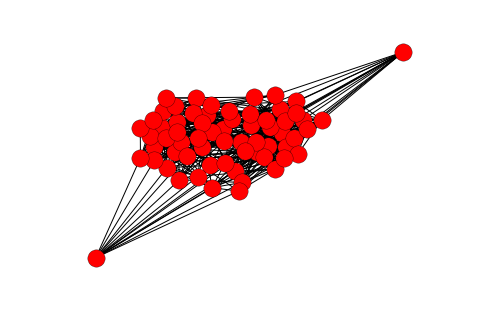

In [34]:

G = nx.from_numpy_matrix(DATA_test[i])
nx.draw(G, nx.spring_layout(G))


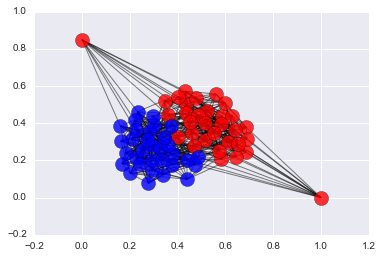

In [35]:

test_perms = [j[3] for j in DATA_triple_test]
test_perms[i]
node_list = inv(test_perms[i])

pos=nx.spring_layout(G)
# nodes
nx.draw_networkx_nodes(G,pos,
                       nodelist=node_list[0:big_community_test],
                       node_color='r',
                       node_size=200,
                   alpha=0.8)
nx.draw_networkx_nodes(G,pos,
                       nodelist= node_list[big_community_test:big_community_test+small_community_test],
                       node_color='b',
                       node_size=200,
                   alpha=0.8)

# edges
nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)

#nx.draw(G, nx.circular_layout(G))

In [45]:
def Spectral_Accuracy(DATA, LABELS):
    """We will assume the data comes out in in the form that DATA_triple is created"""
    
    eigenvectors = np.linalg.eigh(DATA)[1][:,:,0]
    centroides = [sp.cluster.vq.kmeans(np.expand_dims(eigenvectors[i], 1), k_or_guess=2) for i in xrange(len(DATA))]
    
    thresholds = [centroides[j][0][1]+centroides[j][0][0]/2 for j in xrange(len(centroides))]


    labels_bool = [np.less(eigenvectors[i], thresholds[i]) for i in xrange(len(thresholds))]

    labels = [labels_bool[i].astype(float)*2-1 for i in xrange(len(thresholds))]
    labels_flip = [(labels_bool[i].astype(float)*2-1)*-1 for i in xrange(len(thresholds))]

    labels_compare_1 = np.equal(LABELS, labels)
    labels_compare_2 = np.equal(LABELS, labels_flip)

    labels_accuracy1 = np.mean([labels_compare_1[i].astype(float) for i in xrange(len(thresholds))], axis=1)
    labels_accuracy2 = np.mean([labels_compare_2[i].astype(float) for i in xrange(len(thresholds))], axis=1)

    labels_accuarcy = np.maximum(labels_accuracy1, labels_accuracy2)

    return np.mean(labels_accuarcy)

Spectral_Accuracy(DATA_test, LABELS_test)


0.53768157958984375

In [14]:
moretests = DATA_SBM(big_community=6, 
                       small_community=6, 
                       p_in = P_IN,  p_out = P_OUT, 
                       data_points=data_points)
DATA = [i[0] for i in moretests]
LABELS = [i[1] for i in moretests]
Spectral_Accuracy(DATA, LABELS)

0.59004720052083326

What is the Stochastic Block Model SBM: 



[[0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [1 1 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
[[0 1 1 ..., 0 0 0]
 [1 0 1 ..., 0 0 0]
 [1 1 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 1 0]
 [0 0 0 ..., 1 0 1]
 [0 0 0 ..., 0 1 0]]
[[0 0 0 0 1 1 1 1]
 [0 0 0 0 1 1 1 1]
 [0 0 0 0 1 1 1 1]
 [0 0 0 0 1 1 1 1]
 [1 1 1 1 0 0 0 0]
 [1 1 1 1 0 0 0 0]
 [1 1 1 1 0 0 0 0]
 [1 1 1 1 0 0 0 0]]


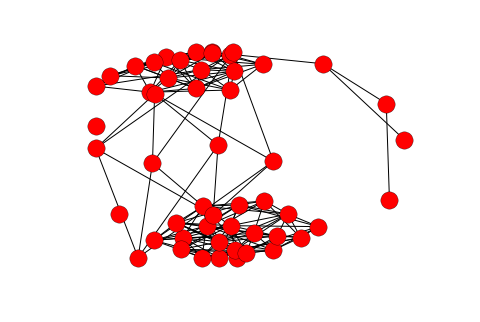

In [15]:
#stochastic block model example
#very little number of paramters needed.  

G1=nx.nx.random_partition_graph([5,3], p_in=0.4, p_out =0.0)
Adj = nx.adjacency_matrix(G1).todense()
print Adj
#we can alter the paramters to see if anything changes
G2=nx.nx.random_partition_graph([20,16], p_in=0.5, p_out =0.0)
Adj = nx.adjacency_matrix(G2).todense()
print Adj
#far more sparse

#and we can have dissociative examples
G3=nx.nx.random_partition_graph([4,4], p_in=0.0, p_out =1.0)
Adj = nx.adjacency_matrix(G3).todense()
print Adj

nx.draw(G1)
nx.draw(G2)
nx.draw(G3)
